# Q0: Your level of cricket experience
Honestly, 1. Although I am familiar with baseball. 

Update: now that I have completed the assignment I would rate it at least as 2 :)

# Q1: Question 1.
Determine the win records (percentage win and total wins) for each team by year and gender,
excluding ties, matches with no result, and matches decided by the DLS method in the event that, for whatever
reason, the planned innings can’t be completed. Consider only data from 2019. Which male and female teams had
the highest win percentages? Which had the highest total wins? Were these teams the same as those with the
highest win percentages? Comment on why the leaders of these two stats might differ.

In [ ]:
! pip install -r ../requirements.txt
! pip install seaborn==0.12.2

In [13]:
import json
import pandas as pd
import pathlib as Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
def load_df_from_json(filename):
    with open(filename) as file:
        df = json.load(file)

    return pd.DataFrame(df)

def filter_odi_df(df, first_year_to_consider=1800):
    """ Remove matches with no winner or with outcome determined by D/L method. 
    Optionally filters out matches before a given year. 
    Returns only relevant columns needed to find win rate.
    """
    df['year'] = pd.to_datetime(df['dates']).dt.year
    df = df[df['year'] >= first_year_to_consider]
    df = df[(df['outcome.method'] != "D/L") & (df['outcome.winner'].notna())]
    df = df.drop_duplicates(subset=['matchid', 'year', 'teams'])
    return df[['matchid', 'gender', 'outcome.winner', 'teams', 'year']].reset_index(drop=True)

def compute_win_rate_table(df):
    win_rate = df.groupby(['teams', 'gender', 'year']).apply(
        lambda group_df: pd.Series({
            'tot_matches': len(group_df),
            'win_counts': (group_df['outcome.winner'] == group_df['teams']).sum(),
            'win_rate': (group_df['outcome.winner'] == group_df['teams']).mean()
        })
    )
    win_rate = win_rate.sort_values(by=['year', 'win_counts'], ascending=[True, False])

    assert all((win_rate['win_rate'] >= 0) & (win_rate['win_rate'] <= 1)), "Some win rate values are out of the expected range."
    assert all(win_rate['tot_matches'] >= 0), "Some total match counts are negative."
    assert all(win_rate['win_counts'] >= 0), "Some win counts are negative."

    return win_rate


def get_win_report(win_rate_df, rate=True):
    """
    Get report year by year and aggregate about team performance for male and female.
    If rate is set to false, the total wins are used instead of the rate
    """
    col = 'win_rate' if rate else 'win_counts'

    # Split the DataFrame into male and female subsets
    male_win_rate_df = win_rate_df.xs('male', level='gender')
    female_win_rate_df = win_rate_df.xs('female', level='gender')

    # Identify teams with most wins per year
    male_df_by_year = male_win_rate_df[col].groupby('year').idxmax().apply(lambda x: x[0])
    female_df_by_year = female_win_rate_df[col].groupby('year').idxmax().apply(lambda x: x[0])

    # Identify team with most wins in aggregate
    male_max_wins_agg = male_win_rate_df[col].idxmax()[0]
    female_max_wins_agg = female_win_rate_df[col].idxmax()[0]

    summary_df = pd.concat([male_df_by_year, female_df_by_year], keys=['Male', 'Female']).rename(f'{col} per year')
    display(summary_df)
    print(f"Most {col} from {first_year_to_consider} for males: {male_max_wins_agg}")
    print(f"Most {col} from {first_year_to_consider} for females: {female_max_wins_agg}")

In [3]:
match_results_path = '../data/match_results.json'
first_year_to_consider = 2019

odi = load_df_from_json(match_results_path)
odi.head(3)

,city,dates,gender,match_type,outcome.runs,outcome.winner,overs,player_of_match,teams,toss.decision,...,ICC.World.XI,Sri.Lanka,supersubs.South.Africa,India,England,supersubs.Pakistan,Australia,Pakistan,supersubs.West.Indies,Bangladesh
0,Brisbane,2017-01-13,male,ODI,92.0,Australia,50,MS Wade,Australia,bat,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Brisbane,2017-01-13,male,ODI,92.0,Australia,50,MS Wade,Pakistan,bat,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,2017-01-15,male,ODI,NaN,Pakistan,50,Mohammad Hafeez,Australia,bat,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
odi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4306 entries, 0 to 4305
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    3636 non-null   object 
 1   dates                   4306 non-null   object 
 2   gender                  4306 non-null   object 
 3   match_type              4306 non-null   object 
 4   outcome.runs            2024 non-null   float64
 5   outcome.winner          4108 non-null   object 
 6   overs                   4306 non-null   int64  
 7   player_of_match         3982 non-null   object 
 8   teams                   4306 non-null   object 
 9   toss.decision           4306 non-null   object 
 10  toss.winner             4306 non-null   object 
 11  umpires                 4306 non-null   object 
 12  venue                   4306 non-null   object 
 13  matchid                 4306 non-null   object 
 14  outcome.wickets         2084 non-null   

It looks like we have two entries for each game, so we have 2153 games in total. One way to handle this would be to combine it into 1 single entry, but I'm not going to do it for now. Also, we don't need most of the columns and some values are only set when a certain event occurs (like outcome.method)

In [5]:
# Find unique values for some interesting columns
for col in ['city', 'gender', 'match_type', 'teams', 'venue', 'outcome.method']:
    n_unique = len(odi[col].unique()) 
    print(f" Number of unique values for column {col} are: {n_unique}")

 Number of unique values for column city are: 150
 Number of unique values for column gender are: 2
 Number of unique values for column match_type are: 1
 Number of unique values for column teams are: 27
 Number of unique values for column venue are: 232
 Number of unique values for column outcome.method are: 2


We have data about 27 diffrent teams. As expected genders are 2 (male, female) and match_type is only ODI. Let's take a look at the cities to see if they include the country.

In [6]:
print(odi['city'].value_counts())

city
Colombo               182
Mirpur                178
London                152
Abu Dhabi              90
Bulawayo               88
                     ... 
Glasgow                 2
Providence              2
Kandy                   2
Queenstown              2
Thiruvananthapuram      2
Name: count, Length: 149, dtype: int64


Unfortunately they don't. It could have been useful later to determine home and away team.

In [7]:
odi.describe()

,outcome.runs,overs,outcome.wickets,neutral_venue,match_type_number
count,2024.000000,4306.0,2084.000000,716.0,1270.000000
mean,74.585968,50.0,5.818618,1.0,3163.891339
std,57.739418,0.0,2.186837,0.0,1207.915674
min,1.000000,50.0,1.000000,1.0,589.000000
25%,26.000000,50.0,4.000000,1.0,2169.250000
50%,62.000000,50.0,6.000000,1.0,3972.000000
75%,110.000000,50.0,7.000000,1.0,4135.750000
max,306.000000,50.0,10.000000,1.0,4295.000000


From this we can get an idea about total runs and wickets. Overs seem to be always 50, but as I understood they could be less if all the batters are outed before the end of the innings. Anyway I don't think we will use this info for Q1.

In [8]:
odi_filt = filter_odi_df(odi, first_year_to_consider=first_year_to_consider)
odi_filt.head(3)

,matchid,gender,outcome.winner,teams,year
0,1144156,male,Pakistan,South Africa,2019
1,1144156,male,Pakistan,Pakistan,2019
2,1144157,male,South Africa,South Africa,2019


In [9]:
odi_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   matchid         490 non-null    object
 1   gender          490 non-null    object
 2   outcome.winner  490 non-null    object
 3   teams           490 non-null    object
 4   year            490 non-null    int32 
dtypes: int32(1), object(4)
memory usage: 17.4+ KB


In [10]:
odi_filt['gender'].value_counts()

gender
male      388
female    102
Name: count, dtype: int64

In [11]:
odi_filt['year'].value_counts()

year
2019    316
2020     92
2021     82
Name: count, dtype: int64

It looks like in 2020 and 2021 there are way less games. Actually, it makes sense because COVID was there. Let's see if it's actually the case by looking at all the other years.

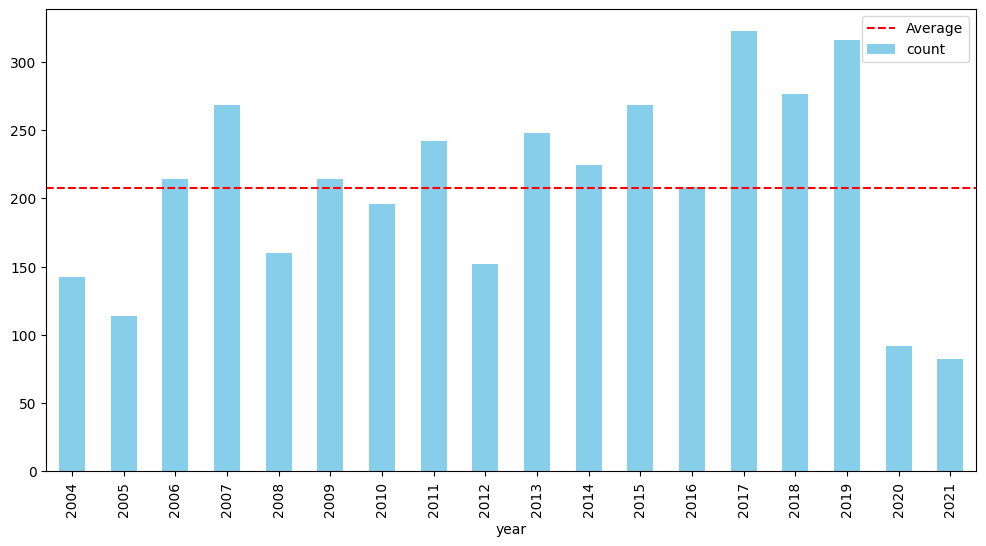

In [12]:
# Let's check now all the past years to see average games
all_years_counts = filter_odi_df(odi, first_year_to_consider=1800)['year'].value_counts()
ax = all_years_counts.sort_index().plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.axhline(y=all_years_counts.mean(), color='r', linestyle='--', label='Average')
plt.legend(); plt.show()

Yes, they are indeed way below average. We can also see there was a positive trend until 2019.
From now on we only consider games from 2019.

In [13]:
# Let's create a new table to check total wins and win rate since we are gonna use it multiple times
win_rate_df = compute_win_rate_table(odi_filt)
win_rate_df.head(3)

,,,tot_matches,win_counts,win_rate
teams,gender,year,,,
Australia,male,2019,23.0,16.0,0.695652
India,male,2019,23.0,15.0,0.652174
England,male,2019,19.0,14.0,0.736842


In [14]:
win_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 66 entries, ('Australia', 'male', 2019) to ('Pakistan', 'female', 2021)
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tot_matches  66 non-null     float64
 1   win_counts   66 non-null     float64
 2   win_rate     66 non-null     float64
dtypes: float64(3)
memory usage: 2.1+ KB


In [15]:
win_rate_df.describe()

,tot_matches,win_counts,win_rate
count,66.000000,66.000000,66.000000
mean,7.424242,3.712121,0.524113
std,5.756764,3.644871,0.301228
min,1.000000,0.000000,0.000000
25%,3.000000,1.000000,0.303922
50%,6.000000,3.000000,0.500000
75%,8.750000,5.000000,0.731203
max,23.000000,16.000000,1.000000


From these stats we can already see that there is a big difference in the amount of games each team has played.

In [16]:
# Display team with most wins for each year and on aggregate
get_win_report(win_rate_df, rate=False)

        year
Male    2019       Australia
        2020       Australia
        2021      Bangladesh
Female  2019       Australia
        2020       Australia
        2021    South Africa
Name: win_counts per year, dtype: object

Most win_counts from 2019 for males: Australia
Most win_counts from 2019 for females: Australia


In [17]:
# Display team with best win rate for each year and on aggregate
get_win_report(win_rate_df, rate=True)

        year
Male    2019    Netherlands
        2020      Sri Lanka
        2021    Afghanistan
Female  2019      Australia
        2020      Australia
        2021      Australia
Name: win_rate per year, dtype: object

Most win_rate from 2019 for males: Netherlands
Most win_rate from 2019 for females: Australia


In [18]:
# Check a specific sample to see if statistically relevant
team = "Afghanistan"
year = 2021
gender = 'male'
print(f"Total matches played by {team} {gender} team in {year}: {win_rate_df.loc[(team, gender, year), 'tot_matches']}, with a win rate of : {win_rate_df.loc[(team, gender, year), 'win_rate']}")

Total matches played by Afghanistan male team in 2021: 3.0, with a win rate of : 1.0


It would be nice to include the total games played in the report, but I'm gonna take a closer look by plotting the data. But from the Afghanistan example we can see that some teams may have 100% rates, but with very few games played.

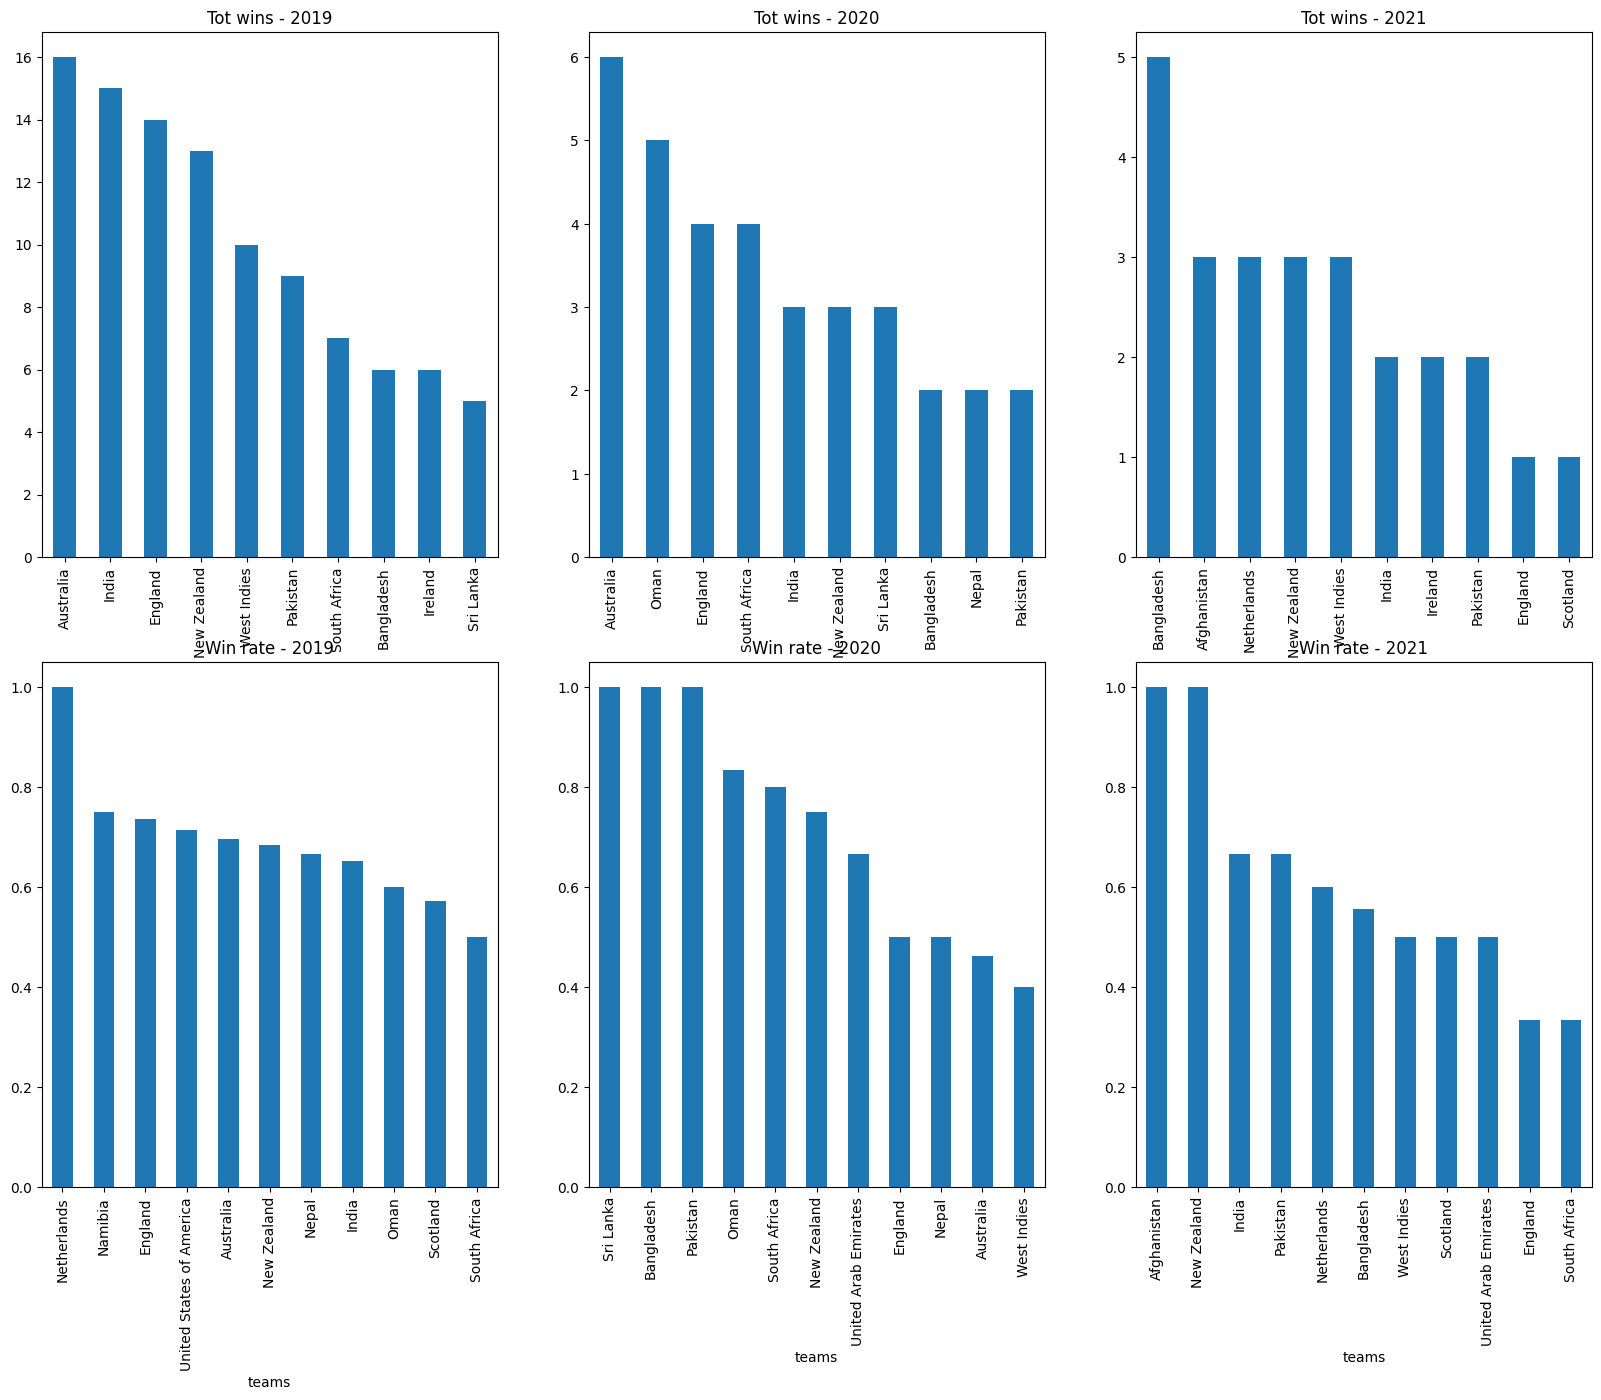

In [19]:
# Let's now go into more details by plotting the male data for each year
years = win_rate_df.index.get_level_values('year').unique()
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
for i, year in enumerate(years):
    win_rate_df.xs((year, 'male'), level=('year', 'gender'))['win_counts'][:10].plot(kind='bar', ax=axs[0, i], title=f"Tot wins - {year}")
    win_rate_df.xs((year, 'male'), level=('year', 'gender'))['win_rate'].sort_values(ascending=False)[:11].plot(kind='bar', ax=axs[1, i], title=f"Win rate - {year}")

I think it's hard to draw conclusions from these plots alone. Let's check the aggregate for the 3 years, but let's consider the total games played as well now.

<Axes: title={'center': 'Aggregate wins from 2019'}, xlabel='teams'>

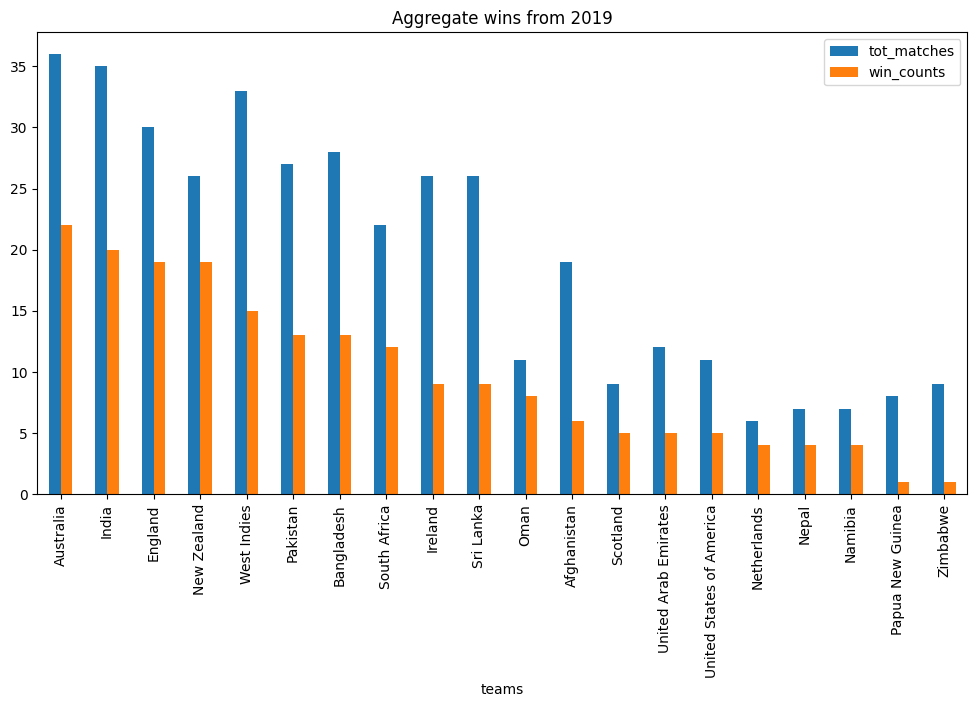

In [20]:
# Let's check the aggregate now of most wins with total matches on the side
win_rate_df.xs('male', level='gender')[['tot_matches', 'win_counts']].groupby('teams').sum().sort_values('win_counts', ascending=False).plot(kind='bar', figsize=(12, 6), title=f"Aggregate wins from {first_year_to_consider}")

If we only consider teams with more than 10 games played, we can see that win rate and total wins start to align a bit more. Indeed Australia, India, England and especially New Zeland seem to have performed the best in the last 3 years (let's keep in mind that COVID maybe affected the results).

Overall I think that the 2 metrics are not comparable and in a context like this one are both useful. Obviously a team that has played more games has more chances to have a higher number of wins. 

In general with international games it is a bit trickier to look at stats like this because each year you may be playing different teams which can be more or less strong. In a national league with fixed teams, these metrics are definately more useful. Nevertheless even here they can give a good hint at the overall team performance.

Finally I tried to track teams performances year by year, but it's a bit challenging given the lack of data for the last 2 years. Nevertheless I think this is a good way to check for trends, especially for regular seasons. For example, if we comfirm that South Africa has played a statistically significant number of games in each 3 years, we could say that they are on a positive trend.

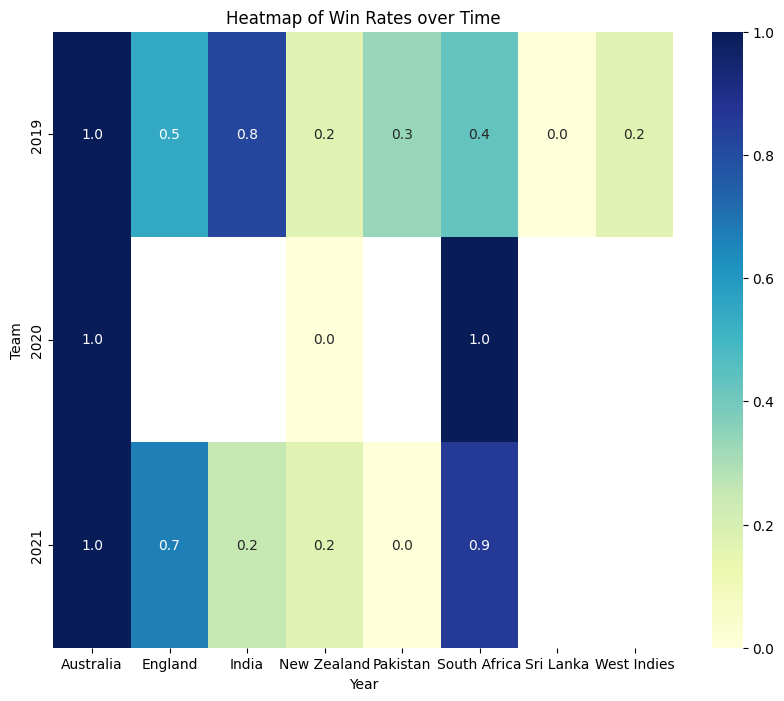

In [21]:
# Assume that 'yearly_win_rate_df' is a DataFrame with teams as index, years as columns, and win rates as values.
yearly_win_rate_df = win_rate_df.xs('female', level='gender').groupby(['year', 'teams']).win_rate.mean().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(yearly_win_rate_df, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title('Heatmap of Win Rates over Time')
plt.xlabel('Year')
plt.ylabel('Team')
plt.show()

# Q2.
Setting aside individual batter production, cricket teams have two main ‘resources’ for producing
runs: remaining overs and wickets. The role resources have on run production is central to the statistical method
known as ‘DLS’, which is used to award a winner in the case of incomplete/disrupted matches. Use the ball-by-ball
summaries under the innings descriptions of each men’s match to make a dataset with the run and wicket outcomes
for each delivery in a match, excluding matches with no result.
Develop a model to predict an average team’s expected runs per over. Please state or include the assump-
tions/validation used to justify your model choice. A visualization prior to modelling could be helpful to justify
your modelling decisions. Save your intermediate data with team, inning order, remaining overs, and remaining
wickets to a JSON/CSV file for Q4. Summarize your conclusions.

In [32]:
def filter_innings_df_with_match_df(innings, odi):
    filtered_match_ids = odi['matchid'].unique()
    assert len(filtered_match_ids) == len(odi) / 2
    innings = innings[innings['matchid'].isin(filtered_match_ids)]
    innings = innings[['matchid', 'innings', 'over', 'runs.total', 'wicket.kind', 'team']]
    innings['over_agg'] = innings['over'].apply(lambda x: int(x.split('.')[0]))
    innings = innings.drop_duplicates(subset=['matchid', 'innings', 'over', 'team'])
    return innings

def add_features_to_overs_df(overs, starting_wickets=10, n_overs=50):
    overs['wickets_cumul'] = overs.groupby(['matchid', 'innings'])['wickets'].cumsum()
    overs['runs_cumul'] = overs.groupby(['matchid', 'innings'])['runs'].cumsum()
    overs['remaining_wickets'] = starting_wickets - overs['wickets_cumul']
    overs['remaining_overs'] = n_overs - overs['over_agg']

    # Add the runs needed to par column
    total_runs = overs.groupby(['matchid', 'innings'])['runs'].sum().reset_index()
    first_innings_runs = total_runs[total_runs['innings'] == 1]
    first_innings_runs = first_innings_runs.rename(columns={'runs': 'first_innings_runs'})
    first_innings_runs = first_innings_runs.drop(columns=['innings'])
    overs = overs.merge(first_innings_runs, on='matchid', how='left')
    # Set to 0 for first innings since no data is available
    overs.loc[overs['innings'] == 1, 'first_innings_runs'] = 0
    overs['runs_needed_to_par'] = overs['first_innings_runs'] - overs['runs_cumul']
    overs.loc[overs['innings'] == 1, 'runs_needed_to_par'] = 0

    overs['last_5_overs_mean_runs'] = overs['runs'].rolling(window=5).mean()
    overs['last_5_overs_mean_runs'].fillna(4, inplace=True) # We should check the actual mean for the first 5 runs
    return overs

def shift_resources(df):
    """Function needed to make sure features refer to the state before the current over
    """
    df['last_5_overs_mean_runs'] = df['last_5_overs_mean_runs'].shift(1)
    df['remaining_wickets'] = df['remaining_wickets'].shift(1)
    df['runs_needed_to_par'] = df['runs_needed_to_par'].shift(1)
    df['runs_cumul'] = df['runs_cumul'].shift(1)

    # Initialize the first row with 10 for remaining overs and wickets, respectively
    df.loc[df.index[0], 'last_5_overs_mean_runs'] = 4
    df.loc[df.index[0], 'remaining_wickets'] = 10
    df.loc[df.index[0], 'runs_cumul'] = 0
    df.loc[df.index[0], 'runs_needed_to_par'] = df.loc[df.index[0], 'first_innings_runs']
    return df

def prepare_dataset(odi_path, innings_path):
    """Function that combines all the preprocessing steps in case we want to skip exploration
    """
    odi = load_df_from_json(odi_path)
    innings = load_df_from_json(innings_path)
    odi_filt = filter_odi_df(odi, first_year_to_consider=1800)
    innings_filt = filter_innings_df_with_match_df(innings, odi_filt)
    overs = innings_filt.groupby(['matchid', 'innings', 'over_agg', 'team']).agg(
        runs=('runs.total', 'sum'),
        wickets=('wicket.kind', 'count')
    ).reset_index()
    overs_ds = add_features_to_overs_df(overs)
    # Shift features so we don't leak the future into the data
    overs_ds = overs_ds.groupby(['matchid', 'innings']).apply(shift_resources)
    # Unpack groups to process it more easily
    overs_ds = overs_ds.drop(columns=['first_innings_runs', 'wickets_cumul']).reset_index(drop=True)
    overs_ds[overs_ds['runs_needed_to_par'] < 0] = 3 
    return overs_ds

### Data exploration and dataset generation

In [33]:
match_results_path = '../data/match_results.json'
innings_results_path = '../data/innings_results.json'

odi = load_df_from_json(match_results_path)
innings = load_df_from_json(innings_results_path)

innings.head(3)

,batsman,bowler,non_striker,runs.batsman,runs.extras,runs.total,over,team,innings,matchid,...,replacements.match.in,replacements.match.out,replacements.match.team,replacements.match.reason,replacements.match.in.1,replacements.match.out.1,replacements.match.reason.1,replacements.match.team.1,extras.penalty,extras.wides
0,DA Warner,Mohammad Amir,TM Head,0,0,0,0.1,Australia,1,1000887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DA Warner,Mohammad Amir,TM Head,0,0,0,0.2,Australia,1,1000887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DA Warner,Mohammad Amir,TM Head,0,0,0,0.3,Australia,1,1000887,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data loading operation is taking around 17 seconds on my machine. If we needed to deploy this script, I would consider using another library such as dask or polars. Or perhaps the data could be stored as a SQL database.

In [24]:
innings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150201 entries, 0 to 1150200
Data columns (total 36 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   batsman                      1150201 non-null  object 
 1   bowler                       1150201 non-null  object 
 2   non_striker                  1150201 non-null  object 
 3   runs.batsman                 1150201 non-null  int64  
 4   runs.extras                  1150201 non-null  int64  
 5   runs.total                   1150201 non-null  int64  
 6   over                         1150201 non-null  object 
 7   team                         1150201 non-null  object 
 8   innings                      1150201 non-null  int64  
 9   matchid                      1142432 non-null  object 
 10  wides                        26286 non-null    float64
 11  wicket.kind                  31857 non-null    object 
 12  wicket.player_out            31857 non-nul

Here I see that we are missing some matchid. Without that we can't refer to the match table.

In [25]:
# Find unique values for some interesting columns
for col in ['batsman', 'bowler', 'non_striker', 'team', 'wicket.kind', 'matchid']:
    n_unique = len(innings[col].unique()) 
    print(f" Number of unique values for column {col} are: {n_unique}")

 Number of unique values for column batsman are: 1789
 Number of unique values for column bowler are: 1369
 Number of unique values for column non_striker are: 1771
 Number of unique values for column team are: 27
 Number of unique values for column wicket.kind are: 10
 Number of unique values for column matchid are: 2103


As expected we have less matches in this table, likely due to those missing values.

Here we can explore some interesting stats like who was the player that batted the most or which is the most common way to be outed. 

In [26]:
print(innings['wicket.kind'].value_counts())

wicket.kind
caught                   17449
bowled                    5661
lbw                       3458
run out                   3367
caught and bowled          959
stumped                    882
retired hurt                48
hit wicket                  27
obstructing the field        6
Name: count, dtype: int64


In [27]:
innings.describe()

,runs.batsman,runs.extras,runs.total,innings,wides,runs.non_boundary,legbyes,noballs,byes,penalty,extras.legbyes,extras.noballs,extras.byes,extras.penalty,extras.wides
count,1.150201e+06,1.150201e+06,1.150201e+06,1.150201e+06,26286.000000,144.0,11438.000000,4226.000000,1714.000000,10.0,1.0,11.0,10.000000,1.0,1.0
mean,7.802662e-01,4.798205e-02,8.282483e-01,1.457288e+00,1.204481,1.0,1.360815,1.039754,2.028588,5.0,1.0,1.0,2.400000,5.0,1.0
std,1.243608e+00,2.907532e-01,1.250046e+00,4.981726e-01,0.789938,0.0,0.873473,0.336118,1.304624,0.0,NaN,0.0,1.429841,NaN,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.0,1.000000,1.000000,1.000000,5.0,1.0,1.0,1.000000,5.0,1.0
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.0,1.000000,1.000000,1.000000,5.0,1.0,1.0,1.000000,5.0,1.0
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.0,1.000000,1.000000,1.000000,5.0,1.0,1.0,2.000000,5.0,1.0
75%,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.000000,1.0,1.000000,1.000000,4.000000,5.0,1.0,1.0,4.000000,5.0,1.0
max,7.000000e+00,6.000000e+00,7.000000e+00,2.000000e+00,5.000000,1.0,5.000000,5.000000,4.000000,5.0,1.0,1.0,4.000000,5.0,1.0


In [28]:
odi_filt = filter_odi_df(odi, first_year_to_consider=1800)
innings_filt = filter_innings_df_with_match_df(innings, odi_filt)
innings_filt.tail(5)

,matchid,innings,over,runs.total,wicket.kind,team,over_agg
1150196,997995,2,46.6,0,NaN,Scotland,46
1150197,997995,2,47.1,0,NaN,Scotland,47
1150198,997995,2,47.2,0,NaN,Scotland,47
1150199,997995,2,47.3,0,NaN,Scotland,47
1150200,997995,2,47.4,4,NaN,Scotland,47


In [29]:
overs = innings_filt.groupby(['matchid', 'innings', 'over_agg', 'team']).agg(
    runs=('runs.total', 'sum'),
    wickets=('wicket.kind', 'count')
).reset_index()

overs.tail(5)

,matchid,innings,over_agg,team,runs,wickets
168673,997995,2,43,Scotland,4,0
168674,997995,2,44,Scotland,2,1
168675,997995,2,45,Scotland,9,0
168676,997995,2,46,Scotland,7,0
168677,997995,2,47,Scotland,4,0


After being unable to beat my lookup table baseline, I decided to add more features to the dataset to check if they led to improvements. Other than remaining overs and wickets, I added cumulative_runs, last_5_mean_runs and runs_needed_to_par.

In [31]:
overs_ds = add_features_to_overs_df(overs)
# Shift features so we don't leak the future into the data
overs_ds = overs_ds.groupby(['matchid', 'innings']).apply(shift_resources)
# Unpack groups to process it more easily and drop columns we don't need anymore
overs_ds = overs_ds.drop(columns=['first_innings_runs', 'wickets_cumul']).reset_index(drop=True)
overs_ds.head(5)

,matchid,innings,over_agg,team,runs,wickets,runs_cumul,remaining_wickets,remaining_overs,runs_needed_to_par,last_5_overs_mean_runs
0,1000887,1,0,Australia,1,0,0.0,10.0,50,0.0,4.0
1,1000887,1,1,Australia,1,0,1.0,10.0,49,0.0,4.0
2,1000887,1,2,Australia,3,0,2.0,10.0,48,0.0,4.0
3,1000887,1,3,Australia,6,0,5.0,10.0,47,0.0,4.0
4,1000887,1,4,Australia,2,2,11.0,10.0,46,0.0,4.0


In [32]:
overs_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168678 entries, 0 to 168677
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   matchid                 168678 non-null  object 
 1   innings                 168678 non-null  int64  
 2   over_agg                168678 non-null  int64  
 3   team                    168678 non-null  object 
 4   runs                    168678 non-null  int64  
 5   wickets                 168678 non-null  int64  
 6   runs_cumul              168678 non-null  float64
 7   remaining_wickets       168678 non-null  float64
 8   remaining_overs         168678 non-null  int64  
 9   runs_needed_to_par      168678 non-null  float64
 10  last_5_overs_mean_runs  168678 non-null  float64
dtypes: float64(4), int64(5), object(2)
memory usage: 14.2+ MB


In [33]:
overs_ds.describe()

,innings,over_agg,runs,wickets,runs_cumul,remaining_wickets,remaining_overs,runs_needed_to_par,last_5_overs_mean_runs
count,168678.000000,168678.000000,168678.000000,168678.000000,168678.000000,168678.000000,168678.000000,168678.000000,168678.000000
mean,1.468004,22.721505,5.059415,0.164420,106.524882,7.117549,27.278495,71.158385,4.999730
std,0.498977,13.858803,3.557709,0.403333,73.224494,2.320682,13.858803,94.264409,1.977594
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-3.000000,0.000000
25%,1.000000,11.000000,2.000000,0.000000,46.000000,6.000000,16.000000,0.000000,3.600000
50%,1.000000,22.000000,4.000000,0.000000,98.000000,8.000000,28.000000,0.000000,4.800000
75%,2.000000,34.000000,7.000000,0.000000,157.000000,9.000000,39.000000,142.000000,6.000000
max,2.000000,49.000000,36.000000,4.000000,474.000000,10.000000,50.000000,481.000000,19.800000


Many useful insights here, but what stands out is the std of 3.6 (70% of mean) for the runs. I see that we have a negative min value in the runs_needed_to_par that we have to deal with. Also mean runs and mean last_5_overs_mean_runs almost match, which is a good sanity check.

In [34]:
# This will return all the rows where cumulative wickets are greater than 10
anomalies = overs_ds[overs_ds['runs_needed_to_par'] < 0]
print(len(anomalies))
display(anomalies)

1


,matchid,innings,over_agg,team,runs,wickets,runs_cumul,remaining_wickets,remaining_overs,runs_needed_to_par,last_5_overs_mean_runs
34382,1153845,2,36,New Zealand,4,0,225.0,8.0,14,-3.0,5.0


In [35]:
# Since it's only one case we can just modify it with a reasonable value (would need better handling though)
overs_ds[overs_ds['runs_needed_to_par'] < 0] = 3 

In [36]:
# Sanity checks
assert overs_ds['runs'].between(0, 36).all()
assert overs_ds['remaining_wickets'].between(0, 10).all()
assert overs_ds['remaining_overs'].between(0, 50).all()
assert overs_ds['wickets'].between(0,6).all()
assert overs_ds['runs_needed_to_par'].between(0,1000*50*6*6).all()
assert overs_ds.isnull().sum().all() == 0
assert overs_ds.duplicated().sum() == 0

In [37]:
# Save intermediate data for Q4
overs_ds[[
                    "matchid",
                    "team",
                    "innings",
                    "remaining_overs",
                    "remaining_wickets",
                    "runs_cumul",
                    "runs_needed_to_par",
                    "last_5_overs_mean_runs",
                    "runs"
]].to_csv('../data/intermediate_data.csv', index=False)

In [ ]:
#  Display full game for debugging
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3):
    display(overs_ds[overs_ds['matchid']=="1153846"])

### Visualizations

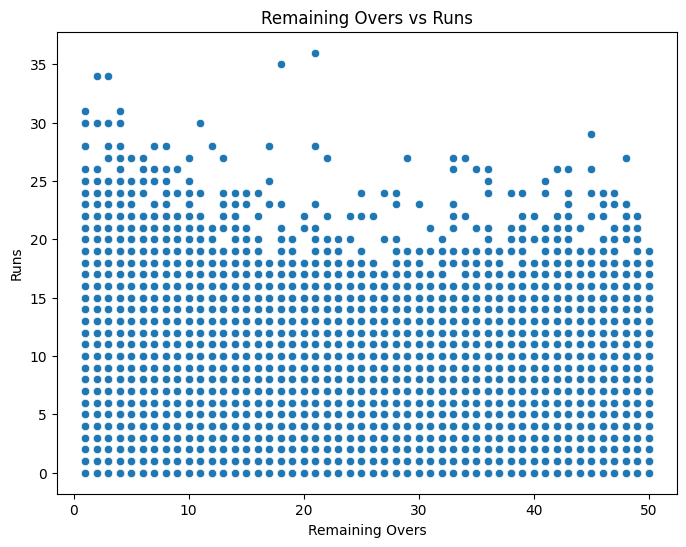

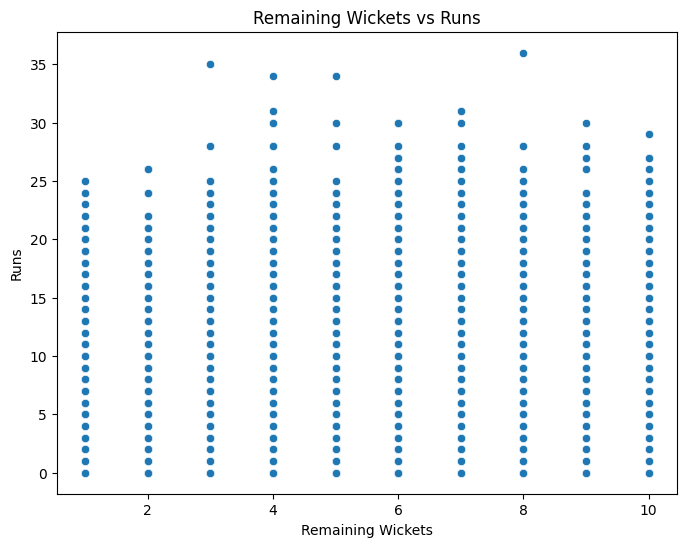

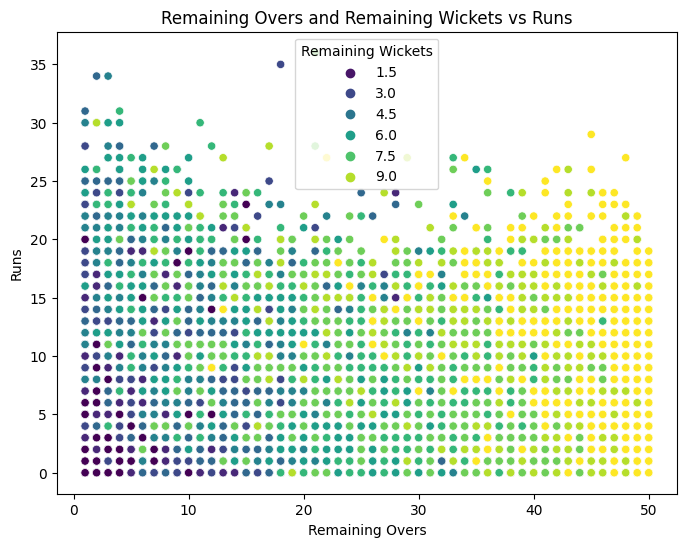

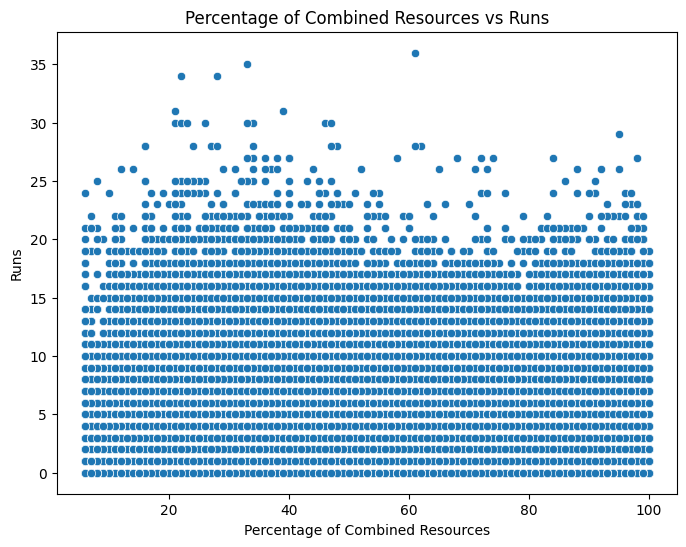

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Remaining overs vs Runs
plt.figure(figsize=(8, 6))
sns.scatterplot(data=overs_ds, x="remaining_overs", y="runs")
plt.title('Remaining Overs vs Runs')
plt.xlabel('Remaining Overs')
plt.ylabel('Runs')
plt.show()

# 2. Remaining wickets vs Runs
plt.figure(figsize=(8, 6))
sns.scatterplot(data=overs_ds, x="remaining_wickets", y="runs")
plt.title('Remaining Wickets vs Runs')
plt.xlabel('Remaining Wickets')
plt.ylabel('Runs')
plt.show()

# 3. Remaining overs and Remaining wickets vs Runs
plt.figure(figsize=(8, 6))
sns.scatterplot(data=overs_ds, x="remaining_overs", y="runs", hue="remaining_wickets", palette="viridis")
plt.title('Remaining Overs and Remaining Wickets vs Runs')
plt.xlabel('Remaining Overs')
plt.ylabel('Runs')
plt.legend(title='Remaining Wickets')
plt.show()

# 4. Percentage of combined resources vs Runs
plt.figure(figsize=(8, 6))
sns.scatterplot(data=overs_ds, x="percentage_of_combined_resources", y="runs")
plt.title('Percentage of Combined Resources vs Runs')
plt.xlabel('Percentage of Combined Resources')
plt.ylabel('Runs')
plt.show()


From the above plots we can see that almost anything can happen in all situations. Let's take a look now at the mean and the frequency.

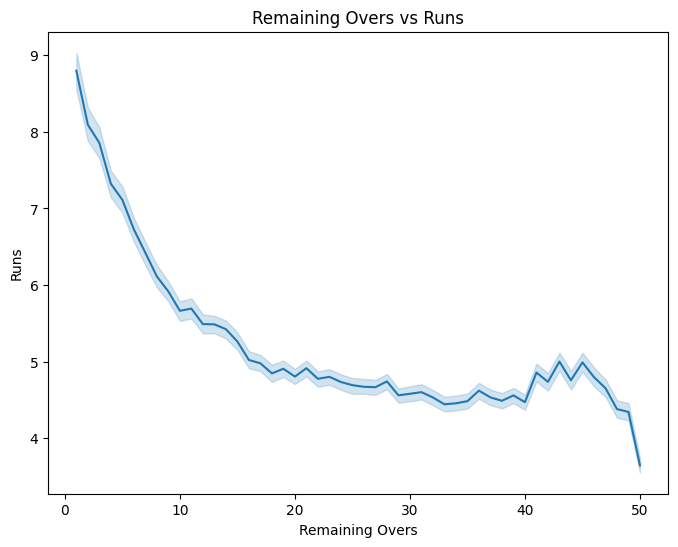

In [124]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=overs_ds, x="remaining_overs", y="runs")
plt.title('Remaining Overs vs Runs')
plt.xlabel('Remaining Overs')
plt.ylabel('Runs')
plt.show()

From this plot we can see that, regardless of the remaining wickets, the teams start quite conservative, then play consistently for the mid part of the game and end it up more aggressively.

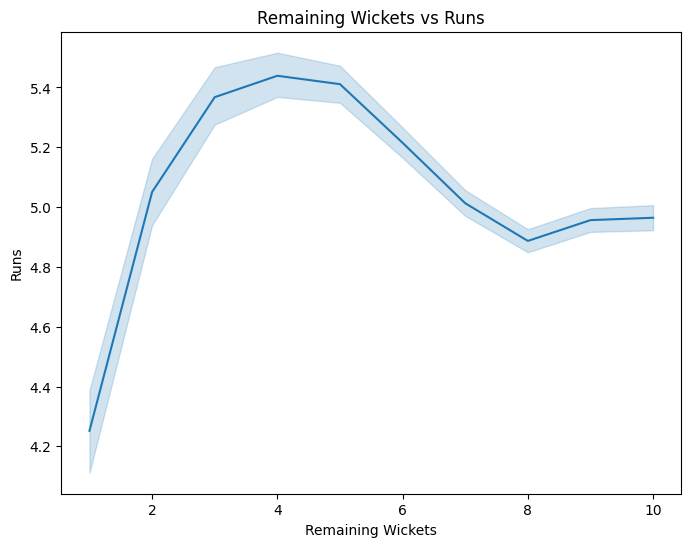

In [125]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=overs_ds, x="remaining_wickets", y="runs")
plt.title('Remaining Wickets vs Runs')
plt.xlabel('Remaining Wickets')
plt.ylabel('Runs')
plt.show()

Here we can see that in general teams are very conservative when they are left with few wickets. It seems they are more aggressive in mid-game compared to start, but this is likely related to the fact that the first few overs are played a bit more conservatively.

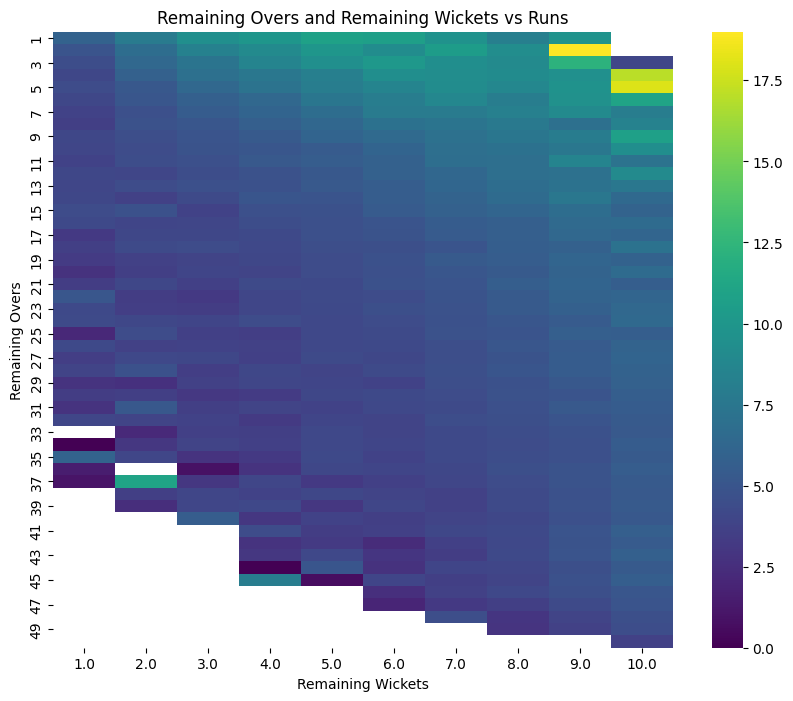

In [126]:
pivot_table = overs_ds.pivot_table(index='remaining_overs', columns='remaining_wickets', values='runs', aggfunc='mean')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis')
plt.title('Remaining Overs and Remaining Wickets vs Runs')
plt.xlabel('Remaining Wickets')
plt.ylabel('Remaining Overs')
plt.show()

This combined visualization is really cool. Indeed, we can see that teams are most aggressive when they have a few overs left, but still have many wickets. I think it also has to do with the fact that the best batters play first.

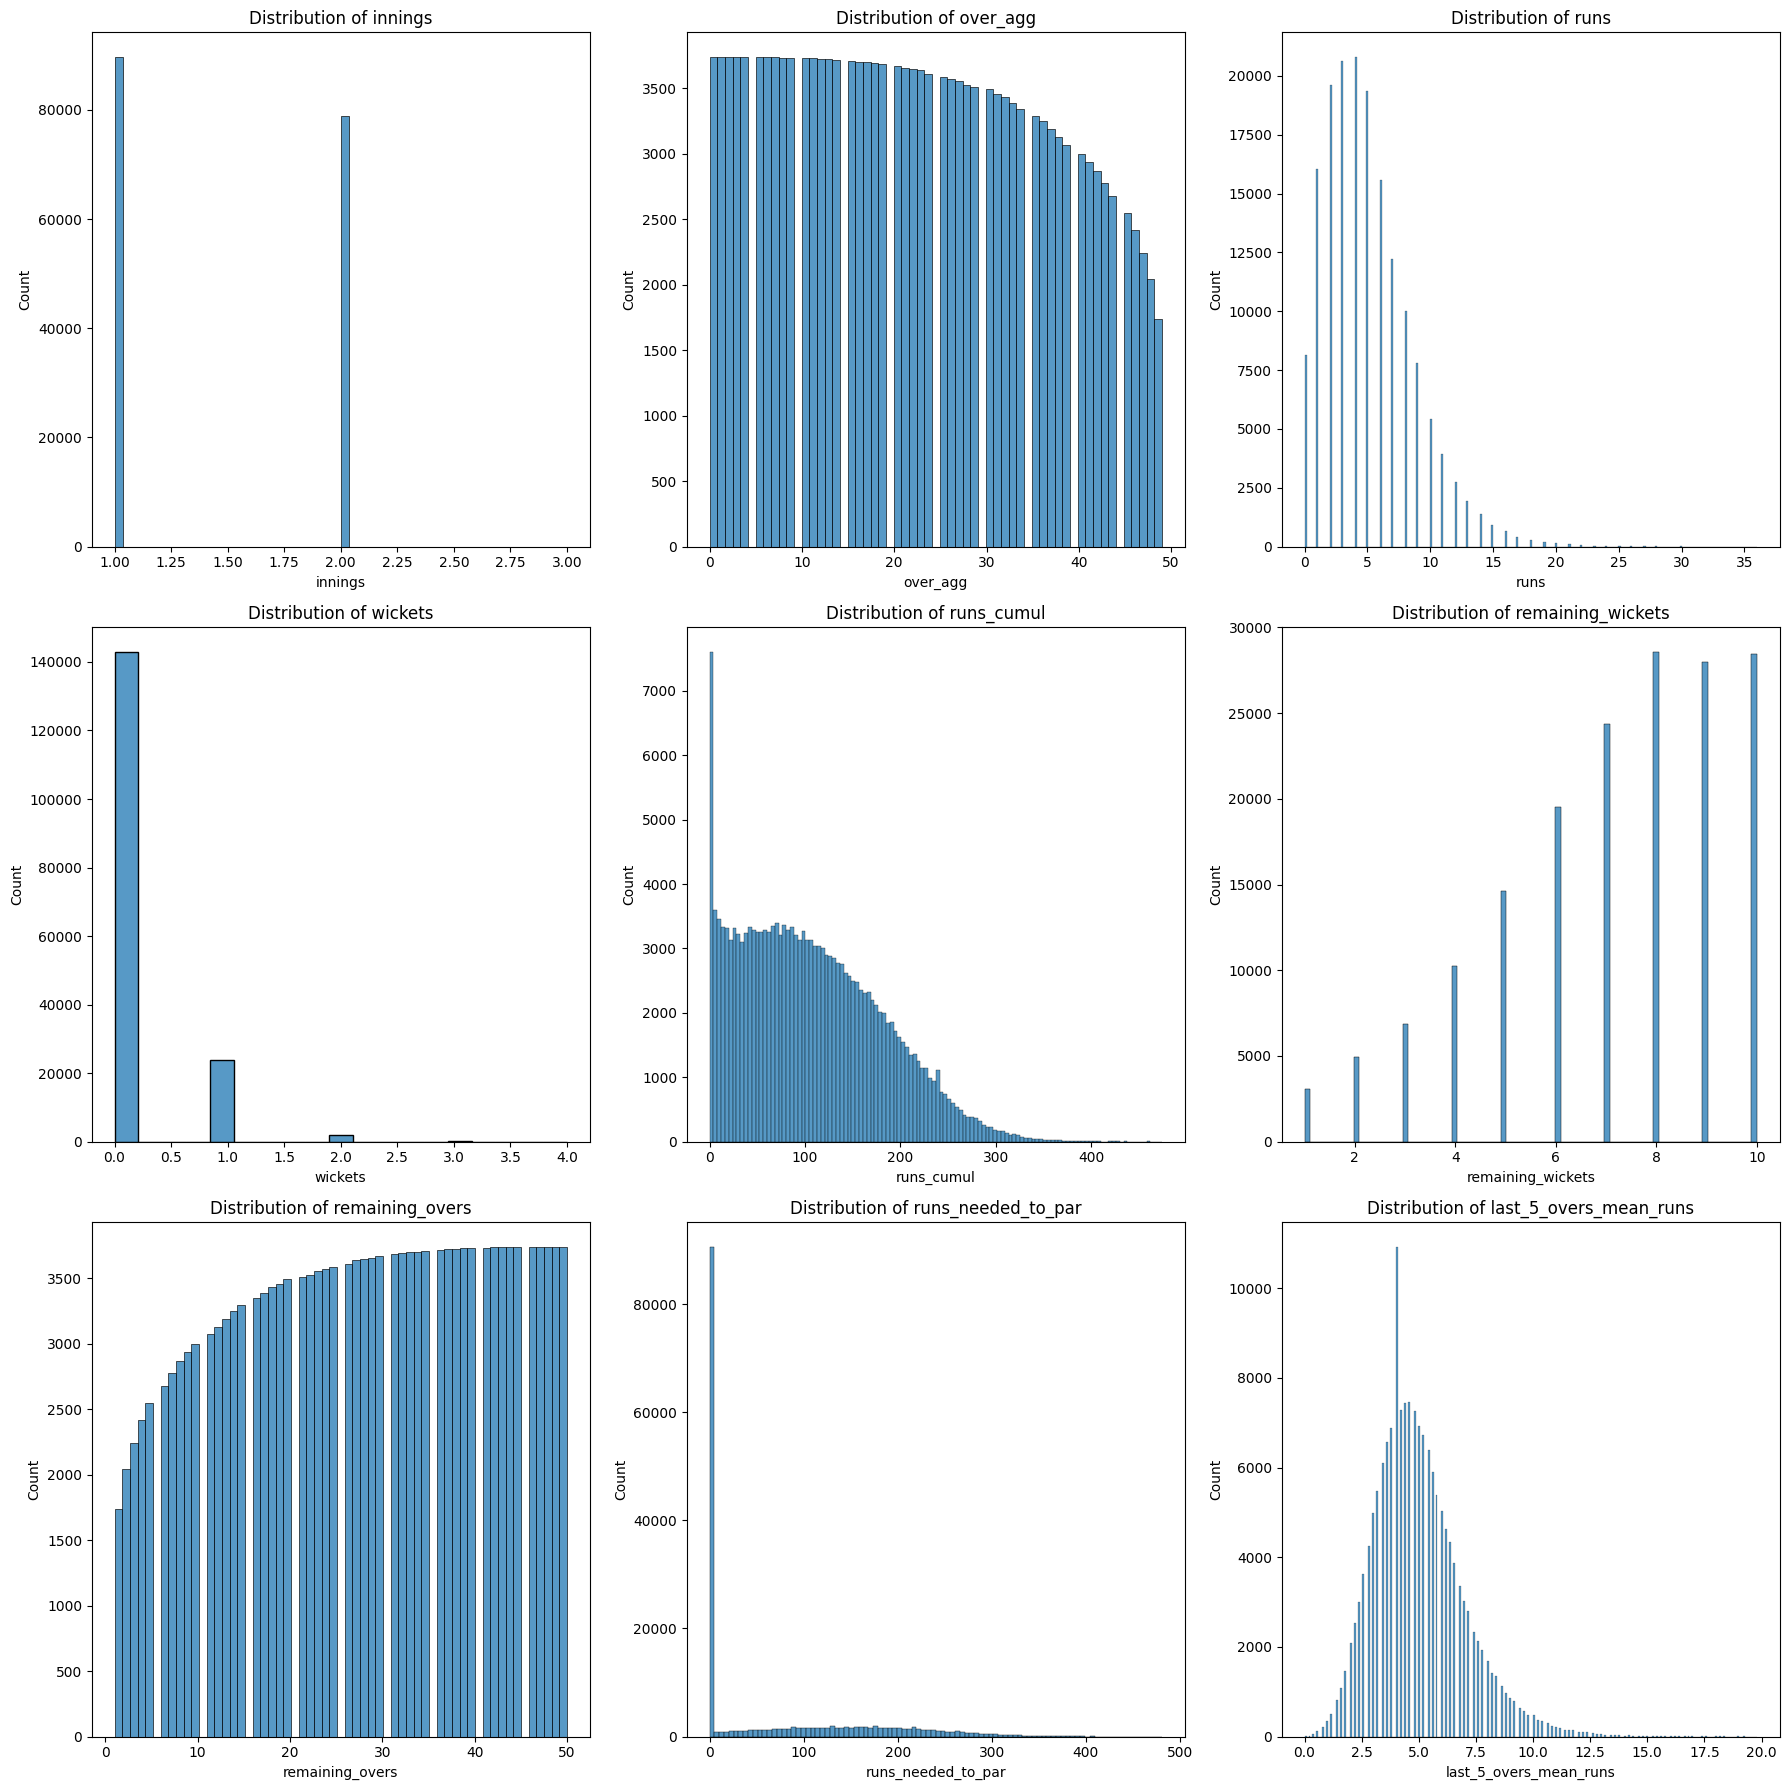

In [132]:
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

features = ['innings', 'over_agg', 'runs', 'wickets', 'runs_cumul', 'remaining_wickets', 'remaining_overs', 'runs_needed_to_par', 'last_5_overs_mean_runs']

for i, ax in enumerate(axs.flatten()):
    if i < len(features):
        sns.histplot(data=overs_ds, x=features[i], ax=ax)
        ax.set_title(f'Distribution of {features[i]}')
        ax.set_xlabel(features[i])
        ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Here we see that most of the variables distributions are kind of skewed. We should take that into account when choosing the features and the models. The spike in runs_needed_to_par is due to the fact that we set to 0 this variable for overs during the first innings. The spike in last_5_overs_mean_runs is due to the way I initialize the the variable in the first 5 overs. Adding a bit of noise to it would likely be beneficial.

In [152]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    corr = df.corr(numeric_only=True)
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

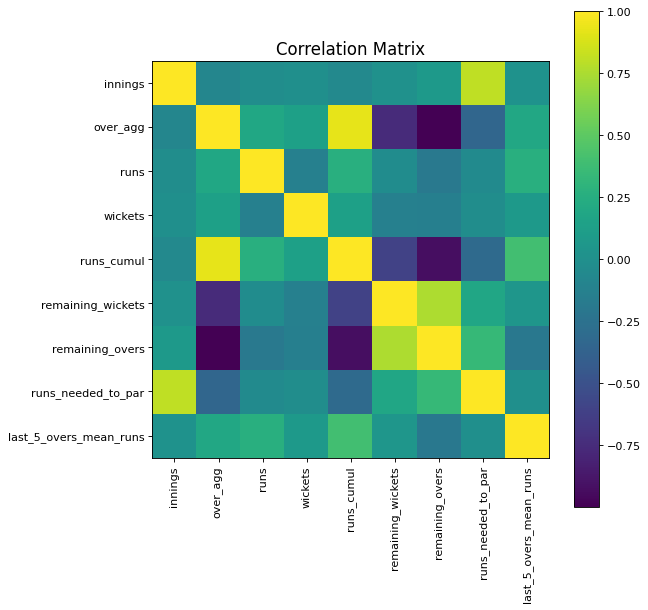

In [148]:
plotCorrelationMatrix(overs_ds, 8)

I always find this super interesting to look at. Overall, all the correlations that we see are expected. Let's look look at some of them:

- **High Positive Correlation between innings and runs_needed_to_par**: This is also quite logical as in the second innings (typically represented by a 2), the runs needed to par will be a function of what was scored in the first innings.

- **Positive Correlation between remaining_wickets and remaining_overs**: Teams with more wickets left are likely to play more remaining overs. This makes sense because teams lose overs when they run out of wickets.

- **High Negative Correlation between remaining_overs and runs_cumul**: This indicates that as the remaining overs decrease (or as the game progresses), the cumulative runs typically increase. This is expected, as teams tend to score more runs as they play more overs. 

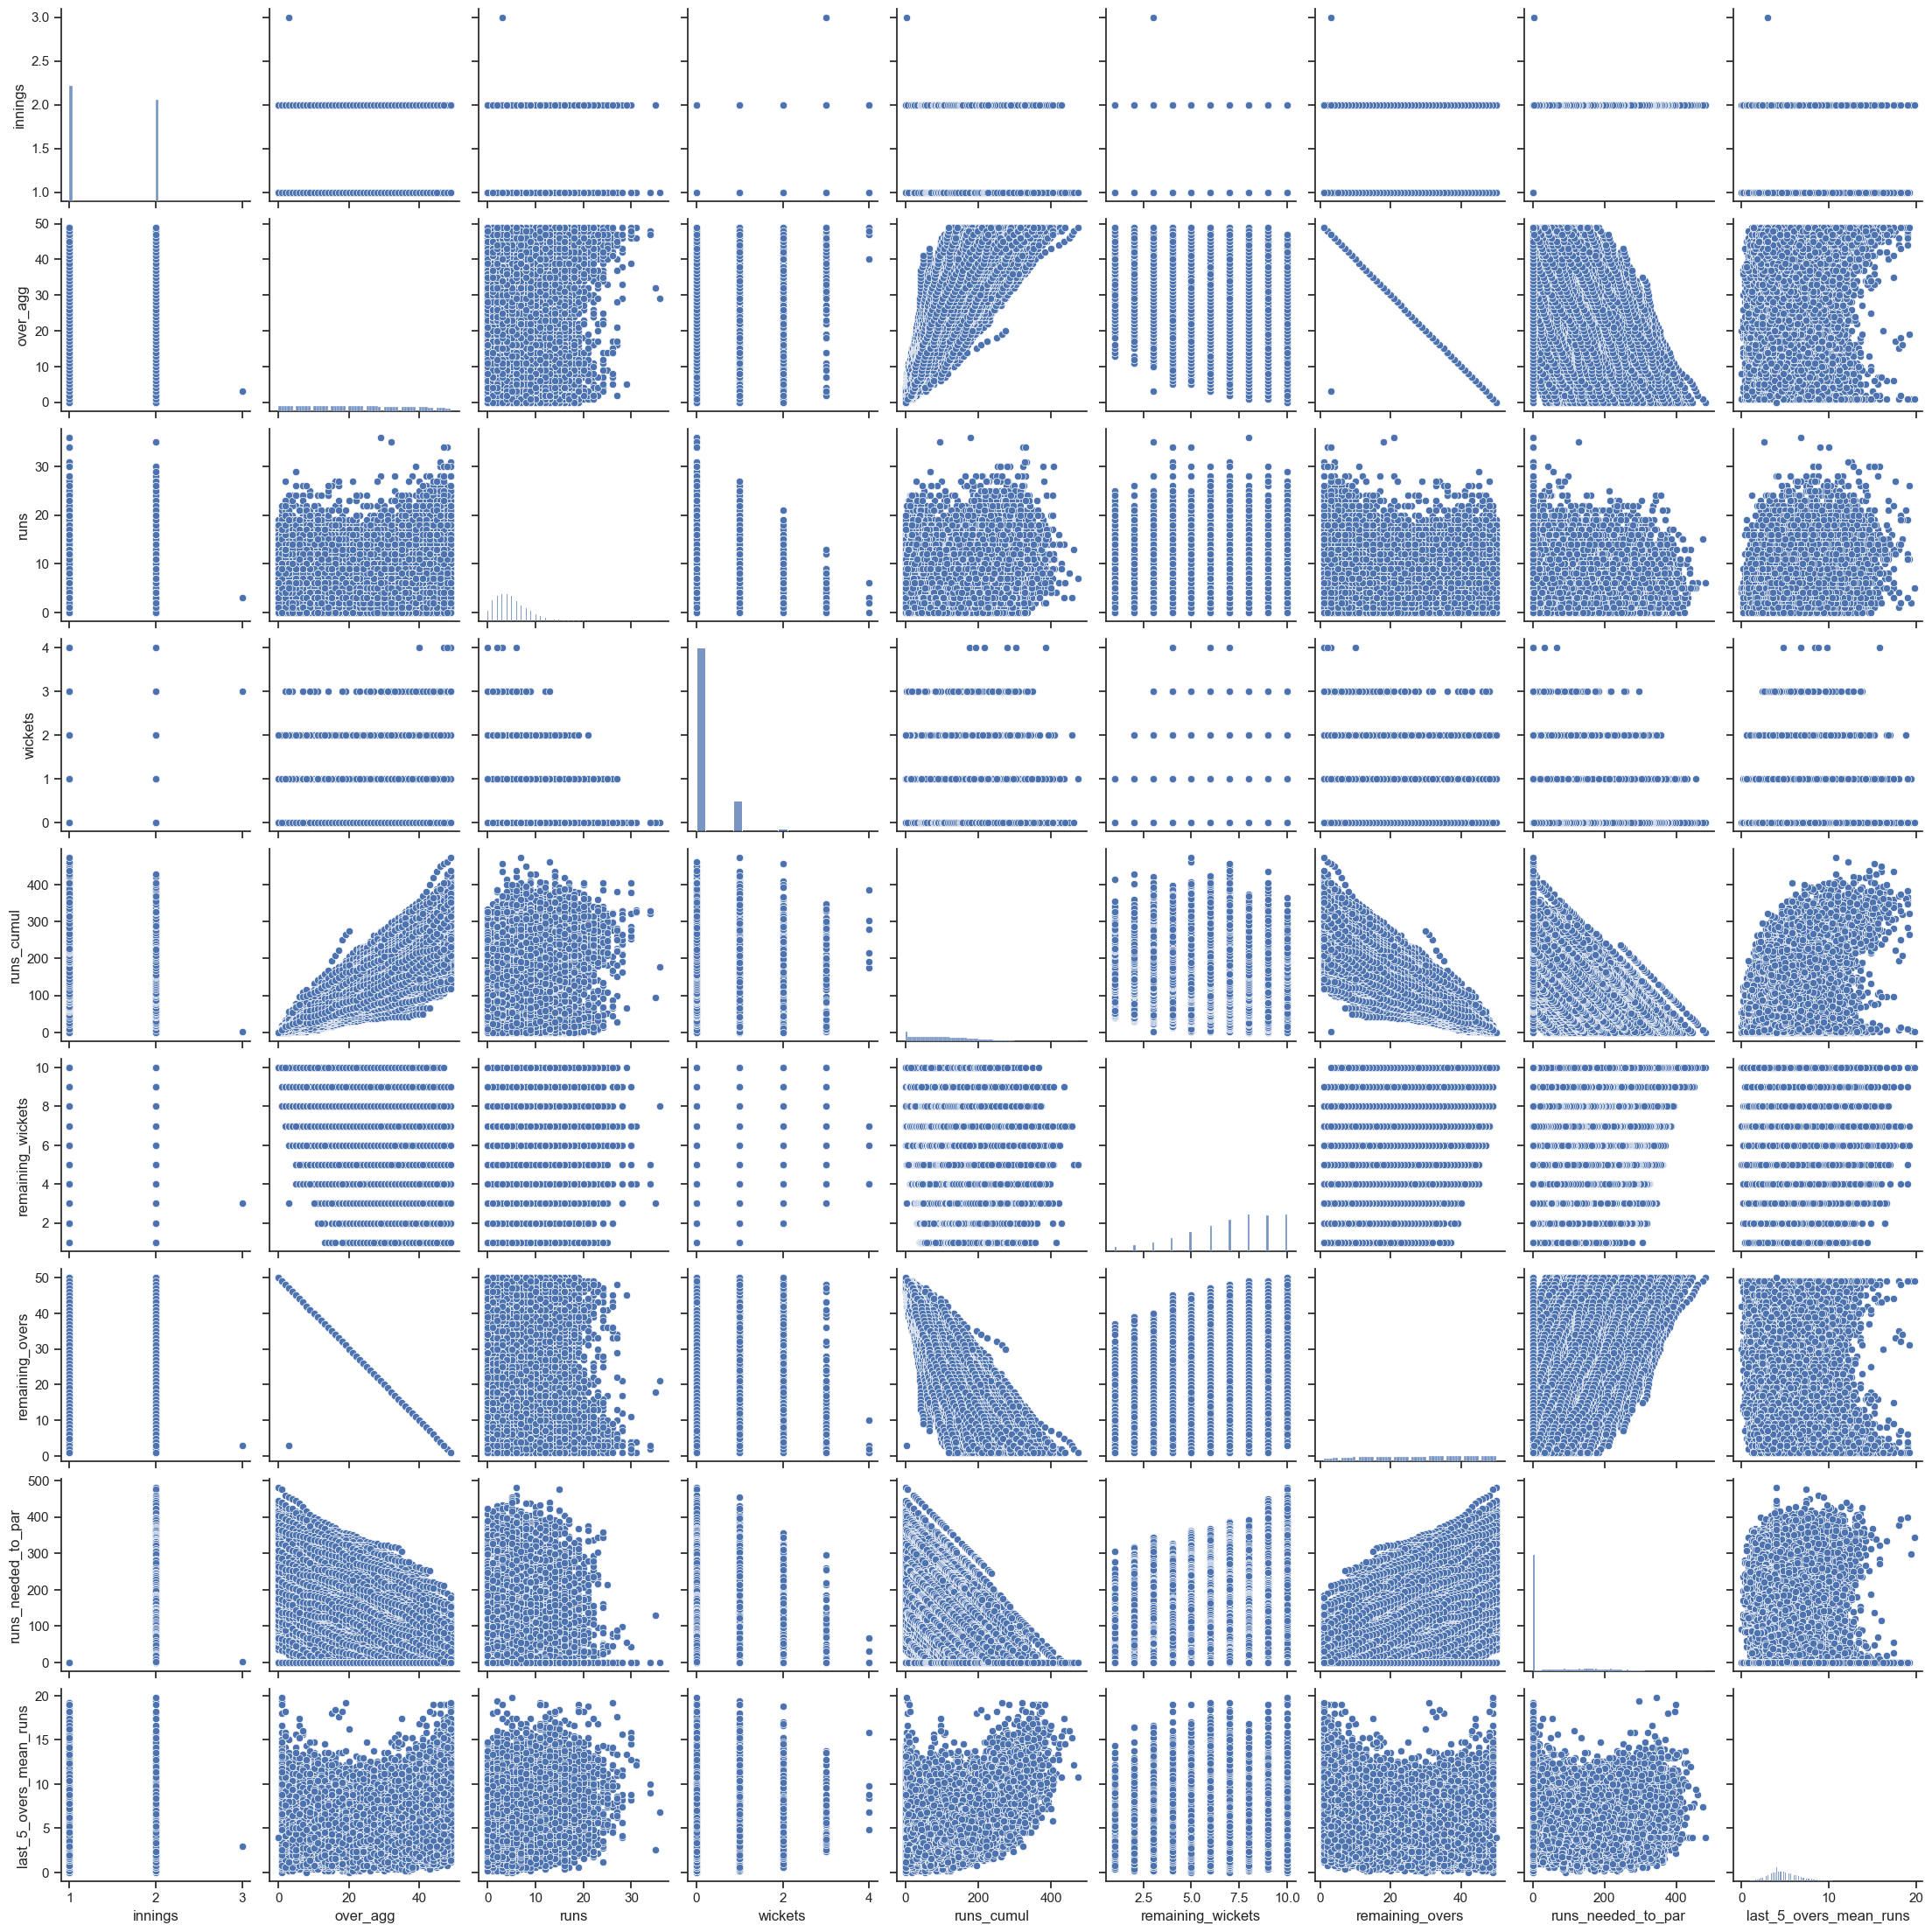

In [5]:
sns.set(style="ticks")
sns.pairplot(overs_ds)

### Model training

In [177]:
np.abs(overs_ds.corr(numeric_only=True)['runs']).sort_values(ascending=False)

runs                      1.000000
last_5_overs_mean_runs    0.263330
runs_cumul                0.261470
over_agg                  0.191380
remaining_overs           0.191368
wickets                   0.132445
runs_needed_to_par        0.046106
remaining_wickets         0.026608
innings                   0.021823
Name: runs, dtype: float64

After visualizing the data, we are left with 2 main choices:

1. Which features to include in the dataset
2. Which model is best suited for the problem

Firstly, for the features, we should choose the ones that are most correlated with the target variable (runs), like runs_cumul, remaining_overs and last_5_overs_mean_runs. Although we have to be careful because remaining_overs and runs_cumul are highly correlated. Runs needed to par can also bring some marginal gains. Finally, surprisingly, remaining_wickets doesn't seem to be so relevant. Propably it would make more sense to include if the last bowl had a wicket. Also I think it could be beneficial to model the innnings separately to exploit more the runs_needed_to_par variable. In conclusion, I will try different combination of the most promising features to see which works best.

For what concerns the model, since our disributions are mostly non-normal, we don't expect linear regression to perform so well. However I want to use it as a baseline. For example, we could apply the log first to make it work.
Afterwards I want to test XGBoost and neural networks, which should be better at modelling the non-linearity of the problem. XGBoost should be good at handling the collinearity of the variables and the neural network should be better at modelling complex relationships.

In [35]:
# Load data if not already done
match_results_path = '../data/match_results.json'
innings_results_path = '../data/innings_results.json'
        
overs_ds = prepare_dataset(match_results_path, innings_results_path)

I want to start by compiling a look up table as baseline, to get an idea of which accuracy to aim for.

In [36]:
def predict_next_over_runs(df, lookup_table):
    # Define a helper function that works on a single row
    def predict_row(row):
        if (row['remaining_wickets'], row['remaining_overs']) in lookup_table:
            return lookup_table.loc[(row['remaining_wickets'], row['remaining_overs'])]
        else:
            return lookup_table.mean() 
    # Apply the helper function to each row in the DataFrame
    df['predicted_runs'] = df.apply(predict_row, axis=1)
    return df

In [37]:
n_test_samples = 5000
lookup_table = overs_ds.iloc[:-n_test_samples].groupby(['remaining_wickets', 'remaining_overs'])['runs'].mean()
lookup_table.fillna(lookup_table.mean(), inplace=True)
pred_df = predict_next_over_runs(overs_ds[-n_test_samples:], lookup_table)
lookup_table_rmse = np.sqrt(((pred_df['predicted_runs'] - overs_ds[-n_test_samples:]['runs'])**2).mean())
print(f"Lookup table rmse: {lookup_table_rmse}")

Lookup table rmse: 3.322641123654614


C:\Users\stefa\AppData\Local\Temp\ipykernel_56312\1980247023.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_runs'] = df.apply(predict_row, axis=1)


In [ ]:
params = {
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.005, 0.01, 0.05, 0.1, 0.5],
    "n_estimators": [100, 500, 1000],
    "colsample_bytree": [0.7,0.9,1.],
    "subsample": [0.7,0.9,1.],
}

xgbc = xgb.XGBClassifier(seed=42)

clf = GridSearchCV(
    estimator=xgbc,
    param_grid=params,
    # n_iter=50,
    cv=5,
    verbose=2,
    n_jobs=-1,
    # random_state=42,
    scoring='f1'
)
tic = time.perf_counter()
clf.fit(X_train, y_train)
print(f"Total time: {time.perf_counter() - tic}")
print(f"Best score: {clf.best_score_}")
print(f"Best params: {clf.best_params_}")

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np

# Let's keep out last 10k samples for test set
X = overs_ds[:-n_test_samples][["remaining_overs", "remaining_wickets", "last_5_overs_mean_runs", "runs_cumul", "runs_needed_to_par", "innings"]]
y = overs_ds[:-n_test_samples]["runs"]
X_test = overs_ds[-n_test_samples:][["remaining_overs", "remaining_wickets", "last_5_overs_mean_runs", "runs_cumul", "runs_needed_to_par", "innings"]]
y_test = overs_ds[-n_test_samples:]["runs"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(objective ='reg:squarederror', n_estimators=500, max_depth=6, eta=0.01, subsample=0.7, colsample_bytree=0.8),
    # "MLP": MLPRegressor(hidden_layer_sizes=(50, 10), learning_rate_init=0.01, max_iter=1000, random_state=1)
}

for model_name, model in models.items():

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train) 
    mse_val = mean_squared_error(y_val, y_pred_val)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_val, y_pred_val)
    print(f"Model: {model_name}")
    print(f"RMSE train: {np.sqrt(mse_train)}")
    print(f"RMSE val: {np.sqrt(mse_val)}")
    print(f"RMSE test: {np.sqrt(mse_test)}")
    print(f"R2 score val: {r2}")
    print("--------------------------")

Model: Linear Regression
RMSE train: 3.3598904416081514
RMSE val: 3.327588434220772
RMSE test: 3.304888809333552
R2 score val: 0.11253782204658047
--------------------------
Model: XGBoost
RMSE train: 3.2792702752757505
RMSE val: 3.278557637925086
RMSE test: 3.2469674595596554
R2 score val: 0.13849800566489456
--------------------------


In [46]:
X_train.columns

Index(['remaining_overs', 'remaining_wickets', 'last_5_overs_mean_runs',
       'runs_cumul', 'runs_needed_to_par', 'innings'],
      dtype='object')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

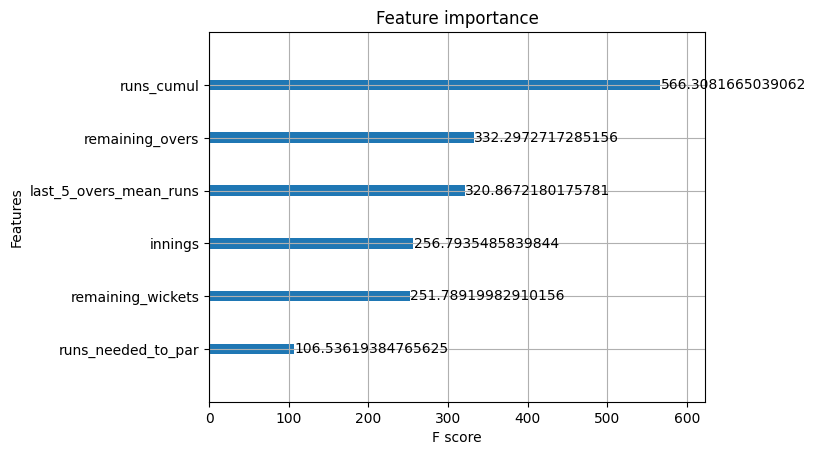

In [43]:
import xgboost as xgb
xgb.plot_importance(models['XGBoost'], importance_type='gain')

From the results we see that linear regression performs similarly to the lookup table, maybe because the features don't really have a normal distribution. XGBoost outperforms the MLP. I manually tuned the hyperparameters for both. With more time I would run a grid search. For XGBoost I played with n_estimators, max_depth and eta. More or less I my tactic was to increase max_depth until model overfitted, then decrease learning rate and increase n_estimators.

Regarding the features, they turned out to be all useful. Here is the progression of the RMSE with XGBoost while adding features: 
| Added feature  | RMSE |
|---|---|
| + remaining_overs  | 3.421  |   
| + remaining_wickets | 3.381  |   
| + last_5_overs_mean_runs |  3.303 |   
| + runs_cumul  | 3.294 |
| + runs_needed_to_par  | 3.281 |
| + innings | 3.279 |

Predicting runs per over is actually a very challenging task, as the single occurence is affected by many factors that are not present in the dataset, like the batter, the bowler, the position of the players in the field etc. Also this value is very noisy as we can see from the plot below.
I then suggest to take a look at what would be the total runs predicted by the model compared to the actual ones. I think this could be a better use of the model. Although in that case we would need to predict the wickets as well.

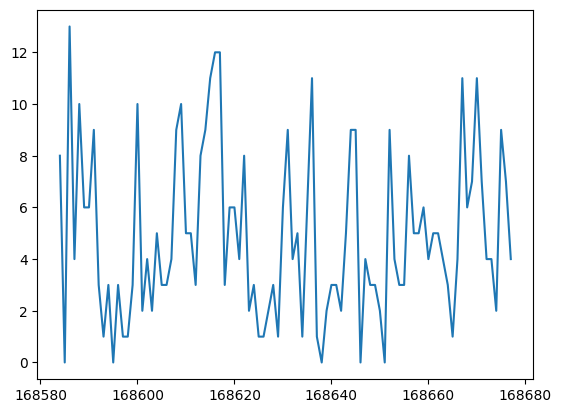

In [74]:
plt.plot(y_test_match)[:50]

In [60]:
test_match = overs_ds[-n_test_samples:]['matchid'].unique()[-1]
X_test_match = overs_ds[(overs_ds['matchid']==test_match)][["remaining_overs", "remaining_wickets", "last_5_overs_mean_runs", "runs_cumul", "runs_needed_to_par", "innings"]]
y_test_match = overs_ds[(overs_ds['matchid']==test_match)]["runs"]

y_pred_test_match = models['XGBoost'].predict(X_test_match)

print(f"Total runs in both innnings: {y_test_match.sum()}")
print(f"Predicted total runs in both innings: {y_pred_test_match.sum()}")

Total runs in both innnings: 457
Predicted total runs in both innings: 455.4720153808594


By looking at this example the model does exceptionally well at giving the full amount of runs. This can indicate that on average the model is accurate, but it's just very hard to exactly guess the single runs per over. 
Still, I need to say that this particular match could be pure luck and I would need to test on way more matches to really validate this assumption.

In [10]:
from joblib import dump
dump(models["XGBoost"], "../models/cricket_model.pkl")

['../models/cricket_model.pkl']

# Q3. 
More generally and unrelated to cricket or the previous questions, model deployment in a production
environment is an important aspect of an engineer’s toolkit. Describe a scalable architecture (a diagram may
be helpful) that would be appropriate for deploying a model that predicts frame-level play values into a cloud
environment with the following assumptions:
• Spatial temporal high frame-rate data (~1 GB per game)
• Play-values are predicted at each frame of a game
• Delivery of game predictions are expected to be delivered overnight
• 500 games per season with 50 games a day
• 5 seasons of existing data
• Model training resources:
– 8 hour runtime with multiple cores (8) and large memory usage
• Model prediction resources:
– 60 min runtime per game with a single CPU and 4 GB of memory usage
List out the services, tooling, and reasoning for the choices of architecture. For example, a LAMP stack could be
appropriate for an internal home network webpage on a Raspberry Pi.

Please refer to the diagram below or open the image placed in the image folder.

Although the question is focused on deployment, I decided to include development as well because I think that you can only have a solid production environment if you set up the dev one properly. 

I propose to use AWS services because they are the ones I'm most familiar with, but any cloud provider would do. Also for simplicity I'm not going to delve into security details.

Overall, I would use Kubeflow to orchestrate tasks, keep track of experiments/models and serve in production. Kubeflow is a workflow management system optimized for machine learning. It runs on kubernetes and it can be integrated into the AWS environment with EKS.

First of all, I would make two accounts, one for development and one for production, so that it is easier to separate costs and also makes it harder for developers to accidentaly modify production setup by limiting its access. Depending on the people available in the team, we could set up also a staging account (with the same architecture as the prod environment), for testing before real deployment.

We can store previous seasons data on a S3 bucket. Since the total data available is around 2.5 TB, and we don't expect exponential increase in the near future, this will suffice. If needed, we can also add an RDS instance to store structured data like game metadata.

Developers can access the data with containerized Jupyter notebooks, ensuring high reproducibility. Each experiment is tracked with kubeflow (integration of other tools like w&b also possible) and the models + training artifacts are stored in a S3 bucket.

When the developers set a new model as baseline, they can define a Kubeflow pipeline to automate model training. This includes retrieving the data, preprocessing and doing the actual training on a AWS machine with GPU. Each step of the pipeline runs in a container that a developer previously pushed to a container registry. This approach ensures reproducibility.

On the production side, we also have a Kubeflow cluster. As soon as the game data is ready (this could be triggered by an API call or an event) a lambda function is run and it launches the inference of the model.  Ideally, the data is already available on an S3 bucket in the production account. We can then store results and metadata in an RDS SQL database and potentially transfer the data to the dev account for future retraining. By using Kubernetes, we can adjust the number of active nodes based on the number of concurrent requests, making this architecture inherently scalable.

Registration of containers to the registry as well as model deployment and testing can be automated with CI/CD linked to pull requests in the git repository.

In terms of costs, for the storage of past games we would spend either 405\\$ or 121\\$ depending on the urgency of retrainings (instant retrieval for the former and up to 12hrs for the latter). Given that we can shut down nodes when we don't use time, inference time in a year is 500 hours. We can further reduce costs by choosing spot instances since we don't need to operate in real time. We can then choose an instance like a m6g.medium, with 4GiB of memory and a single core. This will give a yearly cost of 17.75\\$. 
For training the model the choice will depend if we need access to machines with GPUs. Since we are dealing with videos, this is very likely. We can then choose a g3s.xlarge with 8Gb of vRAM and 4 CPUs, coming at a hourly cost of 0.225\\$ for spot intances. If we consider 1 retraining per week during the season (~32), the cost is 32x8x0.225=57.6\\$

Summing it up, considering periodic retraining, the main fixed cost for this architecture is around 195$ per year.

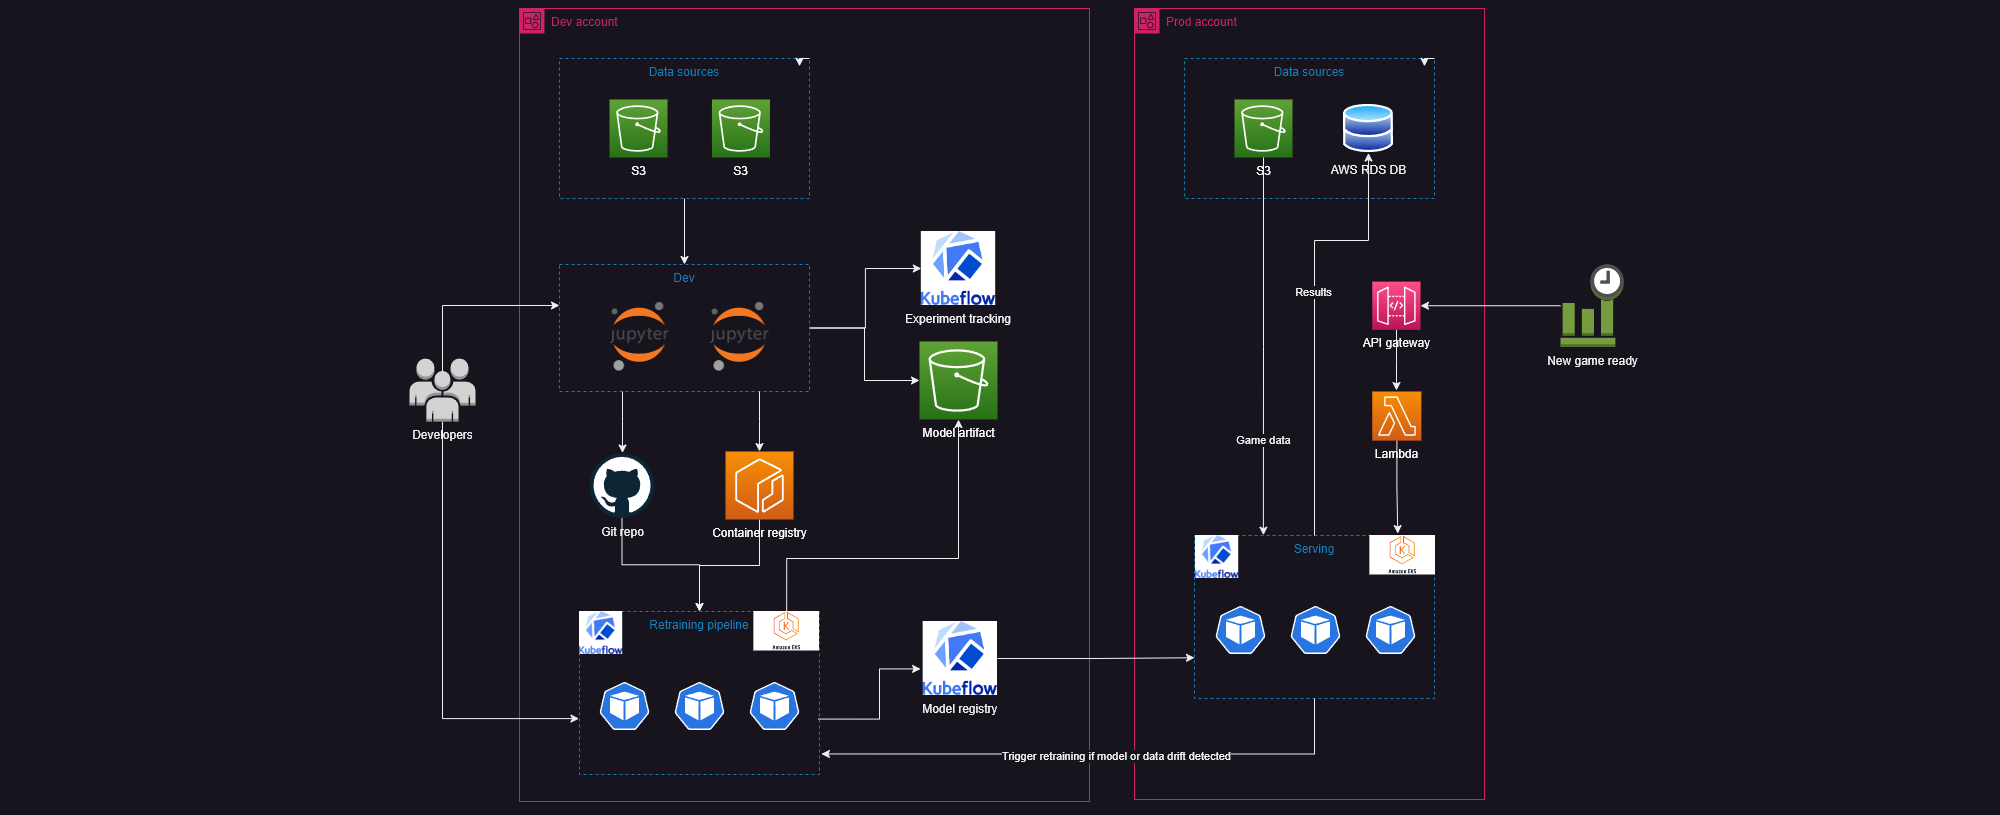

In [38]:
from IPython.display import Image, display
display(Image(filename='../images/architecture-diagram.png'))

# Q4
Question 4. Save your model from Q2 into a file and create a packaged solution for being able to build, deploy
and run your model locally. We are expecting a solution where local runs can be initiated from the command line,
not an API-style deployment. As a way to test your package, create a shell script that takes data saved from Q2,
filters for the first 5 Ireland overs, sends them to your model, and displays the model results to stdout.

In order to run the test you can use the following commands:

- docker build -t cricket-image docker/
- docker run -it cricket-image bash
- (inside the container) python test.py --test